# Case Study - Loan Default Prediction 

### Objective : Build a model that can be used to predict whether a loan will be paid in full or charged off.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, classification_report,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

In [2]:
data = pd.read_csv(r"C:MLCoE_CaseStudy_Dataset.csv")

C:\Users\kulka\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42535 entries, 0 to 42534
Columns: 144 entries, id to settlement_term
dtypes: float64(110), int64(6), object(28)
memory usage: 46.7+ MB


Dataset consist of 42535 records with 144 features 

In [4]:
# Check for Null values in each feature
number_of_nulls = [(col, sum(pd.isnull(data[col]))) for col in data.columns]
number_of_nulls

[('id', 42535),
 ('member_id', 42535),
 ('loan_amnt', 0),
 ('funded_amnt', 0),
 ('funded_amnt_inv', 0),
 ('term', 0),
 ('int_rate', 0),
 ('installment', 0),
 ('grade', 0),
 ('sub_grade', 0),
 ('emp_title', 2626),
 ('emp_length', 1112),
 ('home_ownership', 0),
 ('annual_inc', 4),
 ('verification_status', 0),
 ('issue_d', 0),
 ('loan_status', 0),
 ('pymnt_plan', 0),
 ('url', 42535),
 ('desc', 13293),
 ('purpose', 0),
 ('title', 13),
 ('zip_code', 0),
 ('addr_state', 0),
 ('dti', 0),
 ('delinq_2yrs', 29),
 ('earliest_cr_line', 29),
 ('inq_last_6mths', 29),
 ('mths_since_last_delinq', 26926),
 ('mths_since_last_record', 38884),
 ('open_acc', 29),
 ('pub_rec', 29),
 ('revol_bal', 0),
 ('revol_util', 90),
 ('total_acc', 29),
 ('initial_list_status', 0),
 ('out_prncp', 0),
 ('out_prncp_inv', 0),
 ('total_pymnt', 0),
 ('total_pymnt_inv', 0),
 ('total_rec_prncp', 0),
 ('total_rec_int', 0),
 ('total_rec_late_fee', 0),
 ('recoveries', 0),
 ('collection_recovery_fee', 0),
 ('last_pymnt_d', 83),
 (

Removing the features having more than 70% null values 

In [5]:
data = data.drop([nulls[0] for nulls in number_of_nulls if nulls[1] > 28500], axis=1)

### Data Analysis 

In [6]:
# Exploring the features:All Feature names
all_features = pd.read_csv(r'C:\MLCoE_CaseStudy_DataDictionary.csv')

In [7]:
all_features[['LoanStatNew' ,'Description']]
df_table = pd.DataFrame(all_features)

In [8]:
data_features = df_table[['LoanStatNew','Description']]
data_features = data_features.set_index(['LoanStatNew','Description'])

In [9]:
# 54 Features we got after ramoving values having more than 70% missing values

features = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq','open_acc', 'pub_rec', 'revol_bal', 'revol_util'
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens', 'hardship_flag',
       'debt_settlement_flag']

##### High correlation between total received principal , total payment and loan amount

In [10]:
data_corr = data[['loan_amnt','funded_amnt','int_rate','installment','annual_inc','dti','delinq_2yrs',
                 'open_acc','pub_rec','total_acc','total_pymnt','total_rec_prncp','last_pymnt_amnt','inq_last_6mths']]

data_corr.corr()

,loan_amnt,funded_amnt,installment,annual_inc,dti,delinq_2yrs,open_acc,pub_rec,total_acc,total_pymnt,total_rec_prncp,last_pymnt_amnt,inq_last_6mths
loan_amnt,1.000000,0.981746,0.930869,0.276122,0.065112,-0.032767,0.176525,-0.051636,0.256931,0.882858,0.850882,0.447702,-0.030314
funded_amnt,0.981746,1.000000,0.956522,0.272067,0.064821,-0.033421,0.174705,-0.052625,0.251134,0.899000,0.868776,0.452262,-0.030048
installment,0.930869,0.956522,1.000000,0.278339,0.054948,-0.020096,0.175349,-0.045850,0.233905,0.848611,0.843359,0.400162,-0.010882
annual_inc,0.276122,0.272067,0.278339,1.000000,-0.116559,0.022161,0.168129,-0.016348,0.246163,0.258207,0.259516,0.139387,0.027764
dti,0.065112,0.064821,0.054948,-0.116559,1.000000,-0.036577,0.297951,-0.002854,0.241306,0.063900,0.041432,0.003743,0.014241
delinq_2yrs,-0.032767,-0.033421,-0.020096,0.022161,-0.036577,1.000000,0.014247,0.010305,0.068529,-0.023717,-0.038992,-0.013937,0.020872
open_acc,0.176525,0.174705,0.175349,0.168129,0.297951,0.014247,1.000000,0.005127,0.693161,0.159323,0.157047,0.074552,0.095042
pub_rec,-0.051636,-0.052625,-0.045850,-0.016348,-0.002854,0.010305,0.005127,1.000000,-0.014433,-0.054451,-0.066279,-0.033085,0.059533
total_acc,0.256931,0.251134,0.233905,0.246163,0.241306,0.068529,0.693161,-0.014433,1.000000,0.223726,0.229223,0.159721,0.092396
total_pymnt,0.882858,0.899000,0.848611,0.258207,0.063900,-0.023717,0.159323,-0.054451,0.223726,1.000000,0.972438,0.467013,-0.055705


In [11]:
# Removing Irrelavent Features
irrelavent_columns = ['funded_amnt','last_credit_pull_d','installment','last_pymnt_amnt','initial_list_status','funded_amnt_inv','sub_grade','emp_title','issue_d','pymnt_plan',
                      'desc','purpose','title','zip_code','earliest_cr_line','revol_bal','out_prncp','out_prncp_inv',
                     'total_pymnt_inv','total_rec_prncp', 'total_rec_int','total_rec_int','recoveries','collection_recovery_fee'
                      ,'last_pymnt_d','collections_12_mths_ex_med','policy_code','application_type','tax_liens','hardship_flag','debt_settlement_flag',
                     'pub_rec_bankruptcies','chargeoff_within_12_mths','open_acc','mths_since_last_delinq','total_rec_late_fee']

In [12]:
# New dataframe with the features of interest
data_new = data.drop(labels = irrelavent_columns, axis = 1)

In [13]:
data_new.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec',
       'revol_util', 'total_acc', 'total_pymnt', 'acc_now_delinq',
       'delinq_amnt'],
      dtype='object')

### Visualizing Data

### 1.1 Loan Status

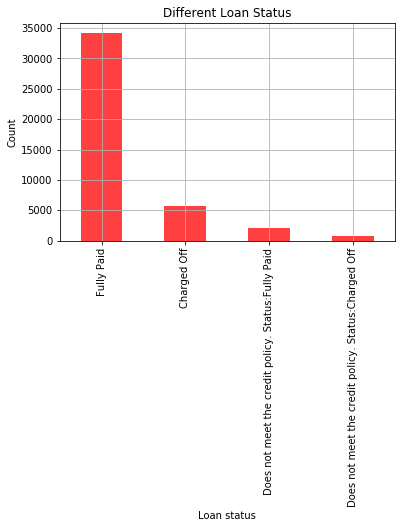

In [14]:
data_new['loan_status'].value_counts().plot(kind= 'bar',grid = True, color = 'red', title = 'Different Loan Status', alpha = 0.75)
plt.xlabel('Loan status')
plt.ylabel('Count')
plt.show()

Converted the status into only 2 values "Fully Paid and Charged off "

In [15]:
# Converting loan status into numerical values
data_new['loan_status'] = data_new['loan_status'].map({'Fully Paid':1,'Does not meet the credit policy. Status:Fully Paid':1,
                                                       'Charged Off':0,'Does not meet the credit policy. Status:Charged Off':0})

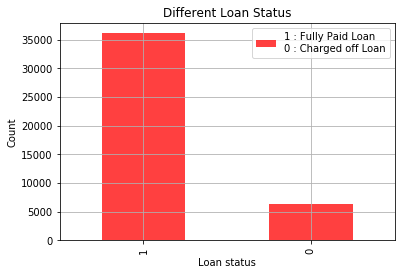

1    36104
0     6431
Name: loan_status, dtype: int64

In [16]:
data_new['loan_status'].value_counts().plot(kind= 'bar',grid = True, color = 'red', title = 'Different Loan Status', alpha = 0.75)
plt.xlabel('Loan status')
plt.ylabel('Count')
plt.legend(['1 : Fully Paid Loan \n0 : Charged off Loan'])
#plt.legend(['0 : Charged off Loan'])
plt.show()
data_new['loan_status'].value_counts()

Around 84 % records have been fully paid while rest have been charged off

### 1.2 Loan Amount

In [17]:
data_new['loan_amnt'].describe()

count    42535.000000
mean     11089.722581
std       7410.938391
min        500.000000
25%       5200.000000
50%       9700.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

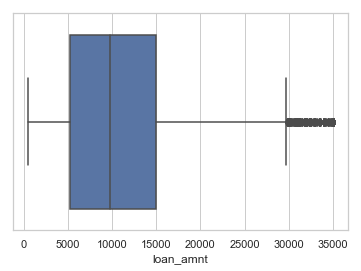

In [18]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=data_new["loan_amnt"])

Most of the customers have the loan amount in the range (10000- 15000) with mean 11080

### 1.3 Interest Rate

In [19]:
# Cleaning interest rate data (Removing % from column)
data_new["int_rate"] = data_new["int_rate"].str.rstrip("%").astype("float")

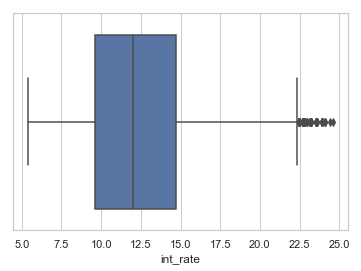

In [20]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=data_new["int_rate"])

Interest rate follows in the range (9.5% to 14.5%) with outliers having interest rate greater than 22%

### 1.4 Employment Length

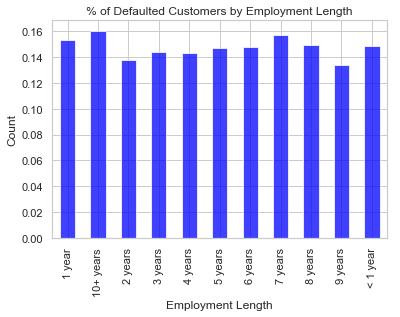

In [21]:
(data_new[data_new['loan_status'] ==0]['emp_length'].value_counts()/data_new['emp_length'].value_counts()).plot(kind= 'bar',grid = True, color = 'blue', title = '% of Defaulted Customers by Employment Length', alpha = 0.75)
plt.xlabel('Employment Length')
plt.ylabel('Count')
plt.show()

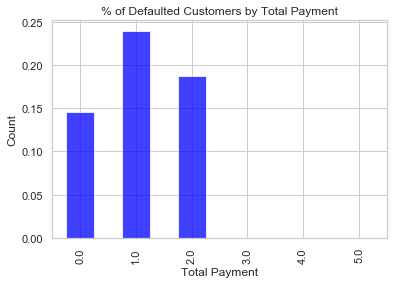

In [22]:
(data_new[data_new['loan_status'] ==0]['pub_rec'].value_counts()/data_new['pub_rec'].value_counts()).plot(kind= 'bar',grid = True, color = 'blue', title = '% of Defaulted Customers by Total Payment', alpha = 0.75)
plt.xlabel('Total Payment')
plt.ylabel('Count')
plt.show()

In [ ]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=data_new["annual_inc"])

### Data Preprocessing and Cleaning

###### 1.Emp_Length - this feature was not formatted properly. It has some values which was in the format like "10+years","5years" etc. Changed them to numerical values.
###### 2.Grade - Borrower's grade given based on his/her past history - encoded to numerical values.
###### 3.home_ownership - This feature encoded to numerical values.
###### 4.Term - Formatted this features such as removing month from column
###### 5.verification_status - Formated this feature and encoded to numerical values
###### 6.Address State - This feature encoded to numerical values with unique value assigned to each state
###### 7.Revolving Utilization - Formated this feature 

In [23]:
data_new['emp_length'] = data_new["emp_length"].replace({'years':'','year':'',' ':'','<':'','\+':''}, regex = True)

In [24]:
data_new['grade'] = data_new['grade'].map({'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1})

In [25]:
data_new['home_ownership'] = data_new['home_ownership'].map({'RENT':1,'MORTGAGE':2,'OWN':3,'OTHER':4,'NONE':5})

In [26]:
data_new['term'] = data_new['term'].map(lambda x: x.lstrip(' ').rstrip('months'))

In [27]:
data_new['verification_status'].str.replace(' ','')
data_new['verification_status'] = data_new['verification_status'].map({'Verified': 1,'Source Verified': 2,'Not Verified': 3})

In [28]:
address = dict(zip(data.addr_state.unique(), range(len(data.addr_state.unique()))))

In [29]:
data_new['addr_state']=data_new['addr_state'].map(address)

In [30]:
data_new['revol_util'] = data_new["revol_util"].str.rstrip("%").astype("float")

### Correlation Between Final Variables

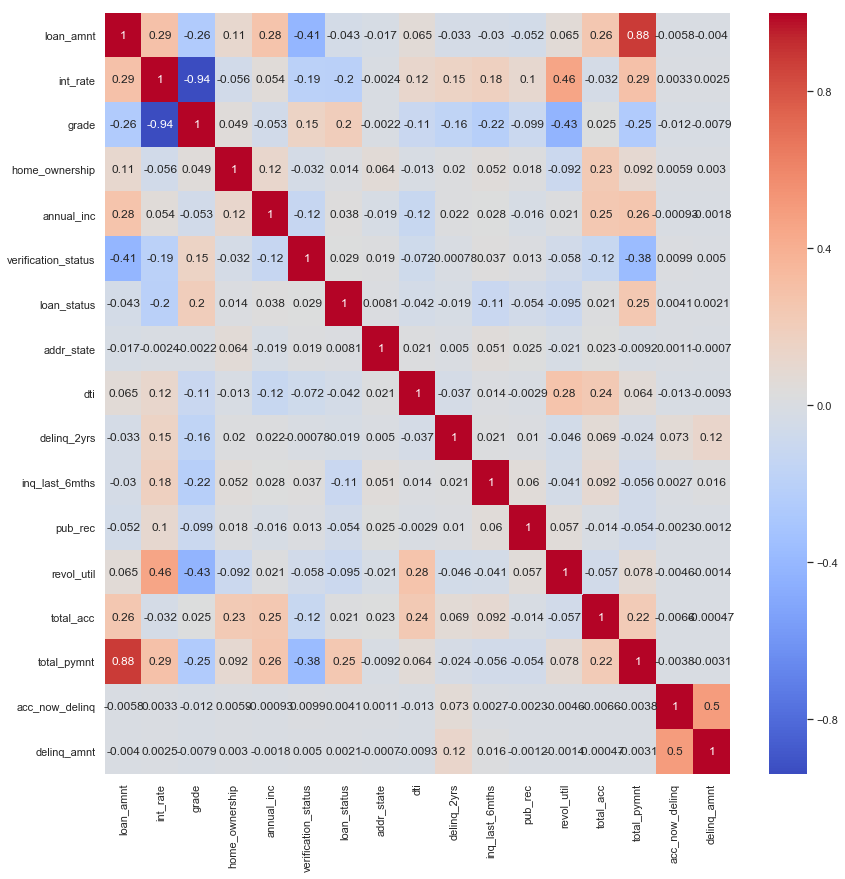

In [31]:
# Set correlation variable
corr = data_new.corr()

# Plot the heatmap
plt.figure(figsize=(14,14))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap='coolwarm',
        annot=True)

### Checking Null Values

In [32]:
# Checking for Null Values

for col in data_new.columns:
    print("{} : {}".format(col, data_new[col].isnull().sum()))

loan_amnt : 0
term : 0
int_rate : 0
grade : 0
emp_length : 1112
home_ownership : 0
annual_inc : 4
verification_status : 0
loan_status : 0
addr_state : 0
dti : 0
delinq_2yrs : 29
inq_last_6mths : 29
pub_rec : 29
revol_util : 90
total_acc : 29
total_pymnt : 0
acc_now_delinq : 29
delinq_amnt : 29


### Dealing with missing values
Remove the records having null values except for rmp_length

In [33]:
data_new = data_new.dropna(subset=['annual_inc','delinq_2yrs','inq_last_6mths','total_acc','pub_rec','revol_util',
                                 'acc_now_delinq','delinq_amnt','total_pymnt'])

In [34]:
# After cleaning Checking for Null Values
for col in data_new.columns:
    print("{} : {}".format(col, data_new[col].isnull().sum()))

loan_amnt : 0
term : 0
int_rate : 0
grade : 0
emp_length : 1109
home_ownership : 0
annual_inc : 0
verification_status : 0
loan_status : 0
addr_state : 0
dti : 0
delinq_2yrs : 0
inq_last_6mths : 0
pub_rec : 0
revol_util : 0
total_acc : 0
total_pymnt : 0
acc_now_delinq : 0
delinq_amnt : 0


### Missing value imputation for Emp_Length using LInear regression

In [35]:
data_emp_features = data_new[['loan_amnt','term','int_rate','grade','annual_inc','emp_length']]

In [36]:
data_emp_features_train = data_emp_features.drop(data_emp_features[(data_emp_features['emp_length'].isnull())].index)

In [37]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(X = data_emp_features_train[['loan_amnt','term','int_rate','grade','annual_inc']], y = data_emp_features_train['emp_length'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [38]:
test = data_emp_features[(data_emp_features['emp_length'].isnull())]

In [39]:
test  = test.drop(['emp_length'],axis =1 )

In [40]:
test_emp_length = model.predict(test)

In [41]:
test['emp_length']=test_emp_length.round(0)

In [42]:
df = data_new 

In [43]:
df["emp_length"].fillna(test['emp_length'], inplace=True)

In [44]:
data_new = df

### Scaling data 

In [45]:
y = data_new['loan_status']

In [46]:
del data_new['loan_status']

In [47]:
X = data_new

In [48]:
# Scaling
scaler=StandardScaler()
X_new = scaler.fit(X)
X_new = scaler.transform(X)

## Building Models with 3 different Approaches

I have built model using three different approaches
1. Without sampling the data
2. Undersampling Technique
3. Oversampling technique (SMOTE) 
Out of these three, model is selected based on highest AUC ROC score with high precision and Recall metrics 

### Approach 1 : Without Sampling data

In [49]:
# Train-Test Split (Stratified)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3,random_state=42)

#### Model1 : Logistic Regression

In [50]:
lr=LogisticRegression(n_jobs=-1,solver='liblinear',class_weight='balanced',penalty = 'l1')
lr.fit(X_train,y_train)
predictions = lr.predict(X_test)
auc_roc_score = roc_auc_score(y_test,predictions)

C:\Users\kulka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [51]:
print("AUC_ROC Score is : ", auc_roc_score )

AUC_ROC Score is :  0.8864735333832778


In [52]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.68      0.84      0.75      1891
           1       0.97      0.93      0.95     10843

    accuracy                           0.92     12734
   macro avg       0.83      0.89      0.85     12734
weighted avg       0.93      0.92      0.92     12734



Text(30.5, 0.5, 'Predicted Label')

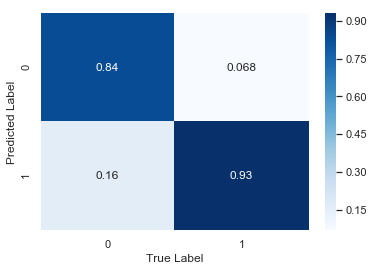

In [53]:
cm = confusion_matrix(y_test, predictions).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label',size=12)
ax.set_ylabel('Predicted Label',size=12)

In [54]:
z = pd.DataFrame(data_new.columns)
z['Variables'] = pd.DataFrame(data_new.columns)

In [55]:
del z[0]

In [56]:
lr.coef = abs(lr.coef_)

In [57]:
a = pd.DataFrame(lr.coef.T)

In [58]:
a['coeficient_value'] = pd.DataFrame(a)

In [59]:
del a[0]

In [60]:
t = pd.concat([z,a],axis =1)

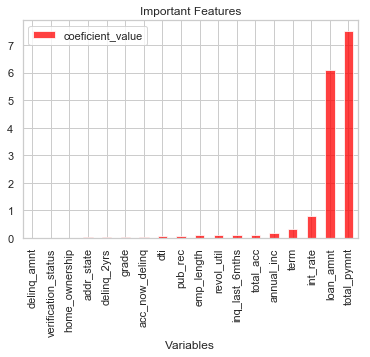

In [61]:
t = t.set_index('Variables')

t.sort_values(by=['coeficient_value']).plot(kind= 'bar',grid = True, color = 'red', title = 'Important Features', alpha = 0.75)

plt.show()

#### Model 2 : Decision Tree with Randomized Search CV

In [62]:
Dtree=DecisionTreeClassifier()
param_dist = {"max_depth": [2, 10],
              "min_samples_split": range(2,10,1),
              "max_features": range(5, 19),
              "min_samples_leaf": range(1, 20),
              "criterion": ["gini", "entropy"]}


tree_cv = RandomizedSearchCV(Dtree, param_dist, cv=5)

# Fit it to the data with the model that has the best score
tree_cv.fit(X_train, y_train)
predictions = tree_cv.predict(X_test)

print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))


AUC_Roc_score = roc_auc_score(y_test,predictions)
print("AUC ROC Score is", AUC_Roc_score )

Tuned Decision Tree Parameters: {'min_samples_split': 8, 'min_samples_leaf': 10, 'max_features': 16, 'max_depth': 10, 'criterion': 'entropy'}
Best score is 0.9528457473662953
AUC ROC Score is 0.8776588872681301


In [63]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1891
           1       0.96      0.98      0.97     10843

    accuracy                           0.95     12734
   macro avg       0.93      0.88      0.90     12734
weighted avg       0.95      0.95      0.95     12734



Text(30.5, 0.5, 'Predicted Label')

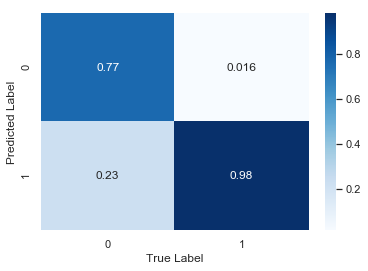

In [64]:
cm = confusion_matrix(y_test, predictions).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label',size=12)
ax.set_ylabel('Predicted Label',size=12)

## Approach 2 : Undersampling the data

In [65]:
undersample = RandomUnderSampler(sampling_strategy=1)
X_new, y = undersample.fit_resample(X_new, y)

# Train-Test Split 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3,random_state=42)

### Model1 : Logistic Regression

In [66]:
lr=LogisticRegression(n_jobs=-1,solver='liblinear',class_weight='balanced',penalty = 'l2')
lr.fit(X_train,y_train)
predictions = lr.predict(X_test)
auc = roc_auc_score(y_test,predictions)

C:\Users\kulka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [67]:
print("AUC ROC Score is : ", AUC_Roc_score )

AUC ROC Score is :  0.8776588872681301


In [68]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88      1948
           1       0.85      0.93      0.89      1898

    accuracy                           0.89      3846
   macro avg       0.89      0.89      0.89      3846
weighted avg       0.89      0.89      0.89      3846



Text(30.5, 0.5, 'Predicted Label')

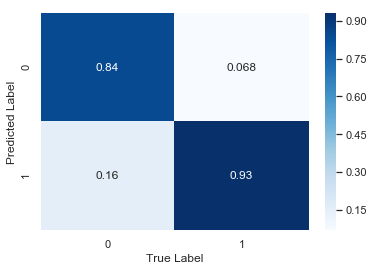

In [69]:
cm = confusion_matrix(y_test, predictions).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label',size=12)
ax.set_ylabel('Predicted Label',size=12)


### Model 2: Decisoin Trees with Randomized Search

In [70]:
Dtree=DecisionTreeClassifier()
param_dist = {"max_depth": [2, 10],
              "min_samples_split": range(2,10,1),
              "max_features": range(5, 19),
              "min_samples_leaf": range(1, 20),
              "criterion": ["gini", "entropy"]}


tree_cv = RandomizedSearchCV(Dtree, param_dist, cv=5)

# Fit it to the data with the model that has the best score
tree_cv.fit(X_train, y_train)
predictions = tree_cv.predict(X_test)

print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))


AUC_Roc_score = roc_auc_score(y_test,predictions)
print("AUC ROC Score is", AUC_Roc_score )

Tuned Decision Tree Parameters: {'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 13, 'max_depth': 10, 'criterion': 'entropy'}
Best score is 0.885309852875613
AUC ROC Score is 0.9042261604671944


In [71]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      1948
           1       0.88      0.94      0.91      1898

    accuracy                           0.90      3846
   macro avg       0.91      0.90      0.90      3846
weighted avg       0.91      0.90      0.90      3846



Text(30.5, 0.5, 'Predicted Label')

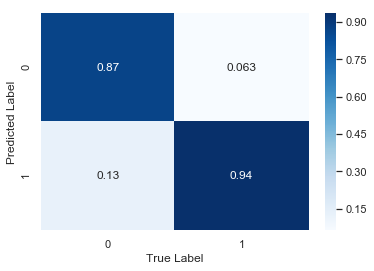

In [72]:
cm = confusion_matrix(y_test, predictions).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label',size=12)
ax.set_ylabel('Predicted Label',size=12)

## Approach 3 : Oversampling the data

In [73]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_new, y = oversample.fit_resample(X_new, y)

# Train-Test Split (Stratified)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3,random_state=42)

### Model 1 : Logistic Regression

In [74]:
lr=LogisticRegression(n_jobs=-1,solver='liblinear',class_weight='balanced')
lr.fit(X_train,y_train)
predictions = lr.predict(X_test)
auc = roc_auc_score(y_test,predictions)

C:\Users\kulka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [75]:
print("AUC ROC Score is : ", AUC_Roc_score )

AUC ROC Score is :  0.9042261604671944


In [76]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88      1948
           1       0.85      0.93      0.89      1898

    accuracy                           0.89      3846
   macro avg       0.89      0.89      0.89      3846
weighted avg       0.89      0.89      0.89      3846



Text(30.5, 0.5, 'Predicted Label')

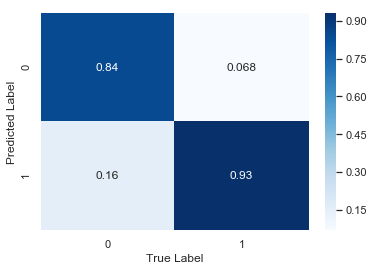

In [77]:
cm = confusion_matrix(y_test, predictions).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label',size=12)
ax.set_ylabel('Predicted Label',size=12)

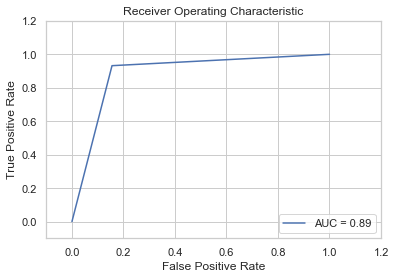

In [78]:

from sklearn import metrics
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
#plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Model 2 : Decision tree with Ramdomized Search

In [80]:
Dtree=DecisionTreeClassifier()
param_dist = {"max_depth": [2, 10],
              "min_samples_split": range(2,10,1),
              "max_features": range(5, 19),
              "min_samples_leaf": range(1, 20),
              "criterion": ["gini", "entropy"]}


tree_cv = RandomizedSearchCV(Dtree, param_dist, cv=5)

# Fit it to the data with the model that has the best score
tree_cv.fit(X_train, y_train)
predictions = tree_cv.predict(X_test)

print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))


AUC_Roc_score = roc_auc_score(y_test,predictions)
print("AUC ROC Score is", AUC_Roc_score )

Tuned Decision Tree Parameters: {'min_samples_split': 9, 'min_samples_leaf': 11, 'max_features': 18, 'max_depth': 10, 'criterion': 'entropy'}
Best score is 0.8892108782880072
AUC ROC Score is 0.9066779469581078


In [81]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1948
           1       0.89      0.93      0.91      1898

    accuracy                           0.91      3846
   macro avg       0.91      0.91      0.91      3846
weighted avg       0.91      0.91      0.91      3846



Text(30.5, 0.5, 'Predicted Label')

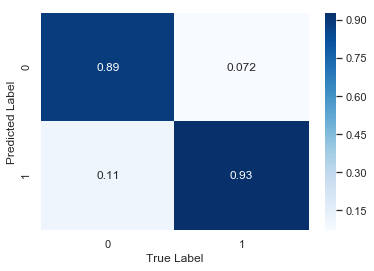

In [82]:
cm = confusion_matrix(y_test, predictions).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label',size=12)
ax.set_ylabel('Predicted Label',size=12)